# Getting started tutorial

## 1. Import of Python packages

A Python package is Python code written by someone else that can be imported into Python so you get access to it. Other words used for packages are modules or libraries. 
A package that contains many functions we need for scientific calculations is named `numpy`.
For example to import the function for calculating square roots we can write:

```python
from numpy import sqrt
print(sqrt(4))
```

To import all function within a package you can use the symbol "`*`", instead of using the name of the
function we want:

```python
from numpy import*
```

Note that, a Python package it self can consist of several other packages. For example we can import from the analysis package `exana` only the statistics package:


```python
from exana.statistics import* 
```

However, this way of importing packages is risky, because we can run into name clashes. This
is the case if for instance two functions in different packages have the same name. 
It therefore recommended to either (1) import only what you need, as we did in the first example, or (2) import packages explicitly with an "alias". For example we can import the `numpy` package with the alias `np`:


```python
import numpy as np
print(np.sqrt(4))
```
Now, all functions in `numpy` are available by writing `np.<name_of_function>`. 


<br>
<div class="alert alert-info">
To see the list of functions available you can write <code>np.</code> (after that package is imported) and then press <kbd>tab</kbd>.
</div>



The most common native Python packages we use are:

In [1]:
import numpy as np                 # mathmatical functions
import matplotlib.pyplot as plt    # plotting
import quantities as pq            # units (sec, meter, etc.)

<br>
<div class="alert alert-info">
<b>Tips:</b> By adding <code>plt.style.use('seaborn')</code>, i.e. using seaborn as theme in matplotlib, you get prettier plots:
</div>


In [2]:
plt.style.use('seaborn')

## 2. Notebook magic

You may sometimes see these lines at the top of notebooks:

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The first two lines make sure that the packages you use in the current notebook is automatically reloaded if they are changed outside Jupyter.

The last line makes sure that plots are interactive and shown in the notebook.

## 3. Projects and actions

### 3.1 Reading project:
In expipe every project has one or multiple actions. An action is usually an axona session. 
To get a project you can type (change project path):

In [4]:
import pathlib
import expipe
project_path = pathlib.Path(r'/home/m/repos/MROS_V1') # CHANGE PROJECT PATH!
project = expipe.get_project(project_path)
project

database_version: 2 project: MROS_V1 type: project

None

To see a list of all actions in the project:

In [5]:
actions = project.actions
actions

### 3.2 Reading an action:

A specific action can be required by using the action-id:  `project.actions[<action-id>]`:

In [6]:
action = actions["1779-130719-17"] # axona_action

From the this action object you can then get the Exdir file where the corresponding data is stored:

In [7]:
import exdir
import exdir.plugins.quantities

exdir_path = action.data_path() / "main.exdir"
exdir_file = exdir.File(exdir_path, plugins=[exdir.plugins.quantities])

Here, `action.data_path()` returns the path to folder containing the Exdir file. To see all folders in the `exdir_file` you can write:

In [8]:
for name in exdir_file:
    print(name)

acquisition
epochs
general
processing
stimulus


## 4. Reading data in Neo

To analyze the data we need to read data in Neo which is  a package for representing electrophysiology data in Python.

### 4.1 Get epochs

<br>
<div class="alert alert-warning">
<b>IMPORTANT:</b> The code below assumes that you have created visual stimulus epoch. For axona data, this can be done by running <code>generate_stim_group_and_epoch(action)</code> in <code>axona_helper.py</code>
</div>


To load all epochs in one action:

In [9]:
import visualstimulation as vs

epochs = vs.data_processing.load_epochs(exdir_path)

# List all epochs:
for epoch in epochs:
    display(epoch.annotations)

{'lazy_shape': None,
 'exdir_path': '/epochs/axona_inp',
 'start_time': array(0.) * s,
 'stop_time': array(139.) * s}

{'lazy_shape': None,
 'exdir_path': '/epochs/visual_stimulus',
 'type': 'visual_stimulus'}

We can get stimulus times, values (orientation), and duration by reading the stimulus epoch, specified by the name: `visual_stimulus`:

In [10]:
stim_epoch = vs.data_processing.get_epoch(epochs, "visual_stimulus")

print("orients:", stim_epoch.labels)
print("times:", stim_epoch.times)
print("durations:", stim_epoch.durations)

orients: [135. 180.   0.  90. 225. 270.  45. 315. 225. 135. 180.  90. 315.   0.
 270.  45.   0.  45. 135.  90. 270. 315. 225. 180. 180.  90. 270.  45.
   0. 315. 135. 225.  45.   0. 135. 225. 180. 270.  90. 315. 270. 180.
 225. 315.   0. 135.  45.  90. 135. 180. 270. 225.  45.  90. 315.   0.
 270. 315. 225.  45.  90. 180. 135.   0. 270.   0.  45.  90. 315. 180.
 225. 135. 315. 270. 180.  45. 225. 135.  90.   0. 315. 135. 180.   0.
  45.  90. 225. 270. 225.   0. 180.  45. 270. 135.  90. 315.] deg
times: [  3.618   5.013   6.343   7.723   9.13   10.514  11.807  13.189  14.596
  15.98   17.373  18.755  20.148  21.53   22.912  24.288  25.672  26.983
  28.388  29.772  31.163  32.548  33.954  35.34   36.73   38.115  39.512
  40.88   42.279  43.656  45.055  46.35   47.726  49.096  50.489  51.871
  53.264  54.646  56.039  57.421  58.814  60.196  61.588  62.971  64.363
  65.746  67.138  68.522  69.912  71.299  72.704  74.089  75.479  76.855
  78.255  79.638  81.03   82.413  83.756  85.139  86.5

### 4.2 Create trials
Next we can create trials based on stimulus. We loop through all channel grounps and their units and store them in a dictionary.  Each unit in this dict consist of 
a list of trials (list of Neo spiketrians) with respect to stimulus timestamps. To retrieve all spiketrains for all channel groups, use:

In [11]:
stim_trials = vs.data_processing.get_stimulus_trials(exdir_path, epochs)

Now we can loop over each channel and their units:

In [12]:
for chx_id, chx in stim_trials.items():
    print(f"channel name: {chx_id}")
    for un_id, trials in chx.items():
        print(f"unit: {un_id}, number of trails: {len(trials)}")  

channel name: 1
unit: 0, number of trails: 96
unit: 1, number of trails: 96
unit: 2, number of trails: 96
channel name: 7
unit: 0, number of trails: 96
unit: 1, number of trails: 96
unit: 2, number of trails: 96
unit: 3, number of trails: 96
channel name: 8
unit: 0, number of trails: 96


### 4.2 Create trials based on orientation

We can sort the the trials above with respect to stimulus orientation:

<IPython.core.display.Javascript object>


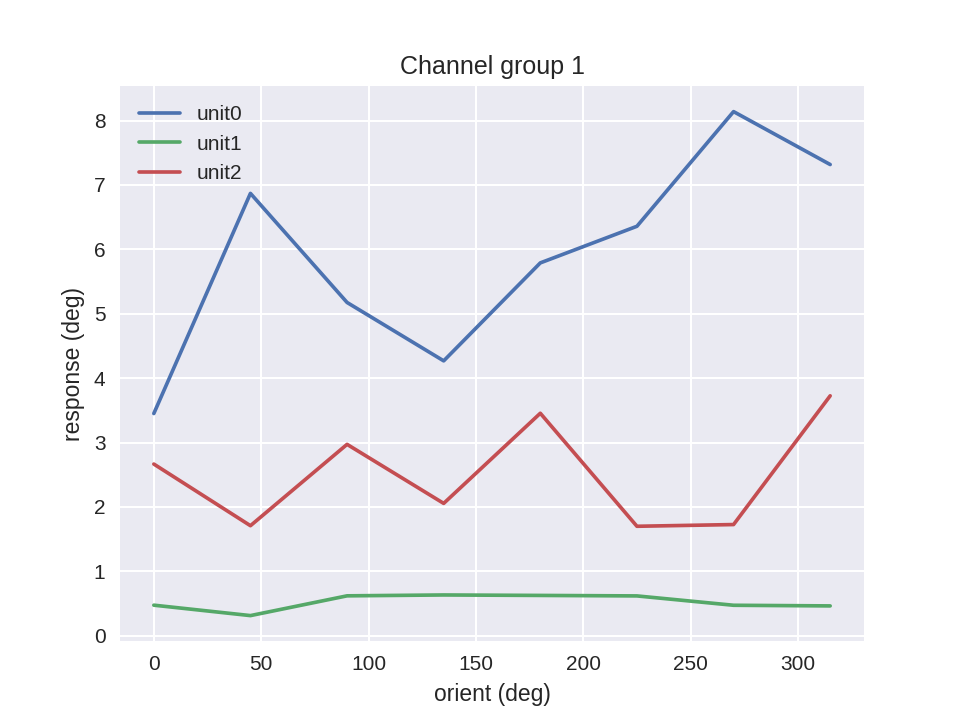

<IPython.core.display.Javascript object>


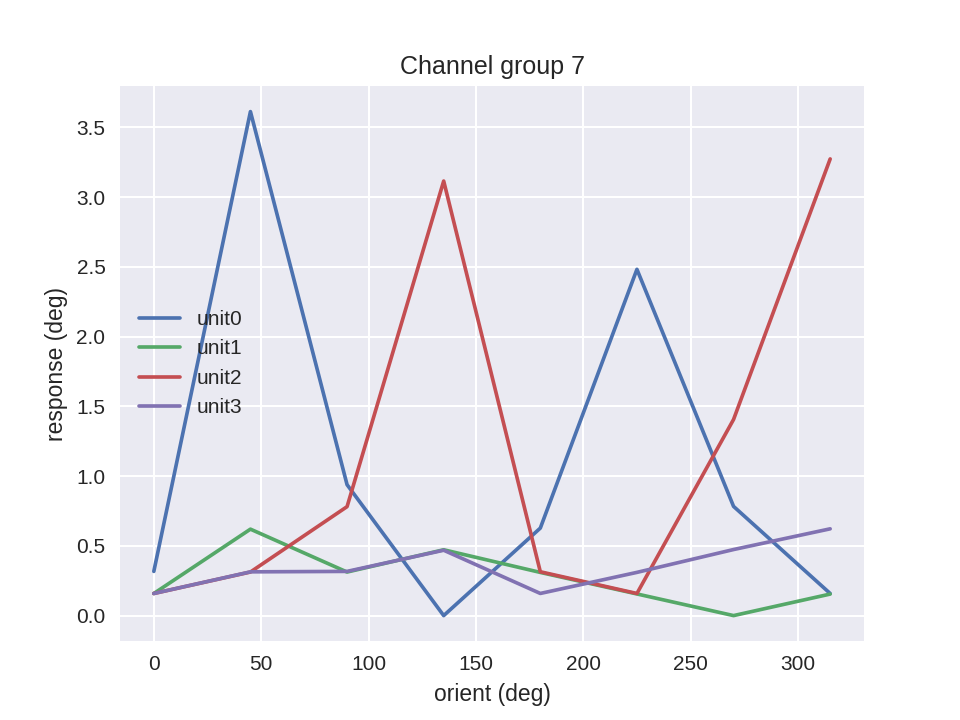

<IPython.core.display.Javascript object>


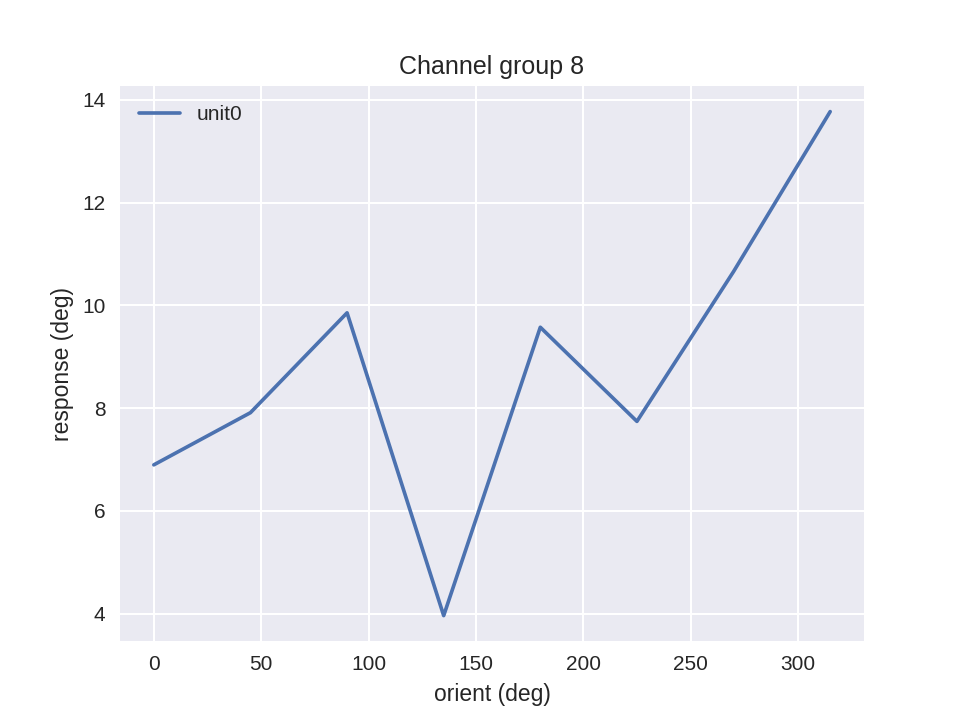

In [13]:
for chx_id, chx in stim_trials.items():
    plt.figure()
    for un_id, trials in chx.items():

        orients_trials = vs.data_processing.make_orientation_trials(trials)      # create orientation trials    
        rates, orients = vs.analysis.compute_orientation_tuning(orients_trials)  # compute orient tuning
        
        plt.plot(orients, rates, label="unit"+str(un_id))
        plt.xlabel("orient (deg)")
        plt.ylabel("response (deg)")
        plt.title(f"Channel group {str(chx_id)}")
    plt.legend()
